# Neural network for classification of contaminants with MAT

## 1. Formulate/outline the problem: classification

Simple neural network for classification of the contaminants using MAT transcriptomes


In [1]:
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
from tensorflow import keras

2023-08-28 13:02:36.118991: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-08-28 13:02:36.172121: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
file_name = "gene_counts_NN_training.csv"

In [3]:
data = pd.read_csv(file_name)

## 2. Identify inputs and outputs

In [4]:
data.head()

,sample,HUNK,KLHL8,ZNF576,UGT1A5,FCF1,SLC2A7,FABP12,TAF12,GLRX,...,ASIC2,TSN,EVA1A,NFATC1,PORCN,GALNT17,DEPDC4,REL,RPL23,AHSP
0,R848,1.0,282.0,84.0,0.0,500.0,0.0,0.0,124.0,281.0,...,0.0,722.0,0.0,688.0,45.0,0.0,0.0,12160.0,6042.0,1.0
1,CRX-527,0.0,35.0,5.0,0.0,63.0,0.0,0.0,14.0,20.0,...,0.0,55.0,0.0,94.0,2.0,0.0,0.0,484.0,746.0,0.0
2,CL-307,3.0,152.0,41.0,0.0,293.0,0.0,0.0,88.0,154.0,...,0.0,462.0,0.0,495.0,38.0,0.0,0.0,4353.0,3391.0,2.0
3,Pam3,0.0,55.0,28.0,0.0,152.0,0.0,0.0,32.0,60.0,...,0.0,204.0,0.0,234.0,10.0,0.0,0.0,1350.0,2014.0,1.0
4,Pam3,0.0,115.0,32.0,0.0,235.0,0.0,0.0,68.0,71.0,...,0.0,375.0,0.0,409.0,23.0,0.0,0.0,3349.0,2760.0,0.0


## 3. Prepare data

In [5]:
data_features = data.drop(columns=["sample"])
target = data["sample"]

In [6]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    data_features, target, test_size=0.2, random_state=0, shuffle=True, stratify=target
)

In [7]:
def to_normalize_DESeq2_style(data):
    # Ensure all values are non-negative
    data = data.applymap(lambda x: max(x, 0))

    # Take the log
    log_data = np.log1p(data)

    # Calculate the pseudo-reference sample for each gene
    log_data["pseudo_reference"] = log_data.mean(axis=1)

    # Filter out genes with -Inf as their average
    filtered_log_data = log_data[log_data["pseudo_reference"] != float("-inf")]

    # Subtract the gene pseudo-references from log counts
    ratio_data = filtered_log_data.iloc[:, :-1].sub(
        filtered_log_data["pseudo_reference"], axis=0
    )

    # Find the median of the ratios for each sample
    sample_medians = ratio_data.median(axis=0)

    # Convert medians to scaling factors
    scaling_factors = np.exp(sample_medians)

    # Divide the original counts by the scaling factors
    manually_normalized = data.div(scaling_factors)

    return manually_normalized


X_train = to_normalize_DESeq2_style(X_train)

X_test = to_normalize_DESeq2_style(X_test)

In [8]:
from sklearn.preprocessing import LabelEncoder

# Initialize the LabelEncoder
label_encoder = LabelEncoder()

# Fit the encoder on the class names and transform them into integers
encoded_labels = label_encoder.fit_transform(y_train)

In [9]:
from sklearn.feature_selection import chi2, SelectKBest

# Define feature selection
fs = SelectKBest(score_func=chi2, k=1000)

# Apply feature selection
X_train = fs.fit_transform(X_train, y_train)

In [10]:
# Transform the test feature matrix
X_test = fs.transform(X_test)

In [11]:
y_train = pd.get_dummies(y_train, dtype=int)
y_test = pd.get_dummies(y_test, dtype=int)

In [12]:
X_train.shape, X_test.shape

((32, 1000), (9, 1000))

In [13]:
y_train.shape, y_test.shape

((32, 9), (9, 9))

## 4. Build an architecture from scratch or choose a pretrained model

In [14]:
keras.backend.clear_session()
keras.utils.set_random_seed(2)

In [15]:
callback = keras.callbacks.EarlyStopping(monitor="loss", patience=3)

In [16]:
# create our model
def create_nn():
    inputs = keras.Input(shape=X_train.shape[1])
    x = keras.layers.UnitNormalization()(inputs)
    x = keras.layers.Dropout(0.3)(x)
    x = keras.layers.Dense(
        256, activation="relu", kernel_regularizer=keras.regularizers.L2(0.01)
    )(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Dropout(0.2)(x)
    x = keras.layers.Dense(
        128, activation="relu", kernel_regularizer=keras.regularizers.L2(0.01)
    )(x)
    x = keras.layers.Dropout(0.1)(x)
    outputs = keras.layers.Dense(9, activation="softmax")(x)

    model = keras.Model(inputs=inputs, outputs=outputs, name="small_NN")
    return model


model = create_nn()
model.summary()

Model: "small_NN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1000)]            0         
                                                                 
 unit_normalization (UnitNor  (None, 1000)             0         
 malization)                                                     
                                                                 
 dropout (Dropout)           (None, 1000)              0         
                                                                 
 dense (Dense)               (None, 256)               256256    
                                                                 
 batch_normalization (BatchN  (None, 256)              1024      
 ormalization)                                                   
                                                                 
 dropout_1 (Dropout)         (None, 256)               0  

## 5. Choose a loss function and optimizer

In [17]:
def compile_model(model):
    model.compile(
        optimizer="adam",
        loss=keras.losses.CategoricalCrossentropy(),
        metrics=["accuracy", keras.metrics.AUC()],
    )


compile_model(model)

## 6. Train model

In [18]:
history = model.fit(
    X_train, y_train, epochs=300, callbacks=[callback], validation_data=(X_test, y_test)
)

Epoch 1/300
1/1 [==============================] - 2s 2s/step - loss: 8.1466 - accuracy: 0.2188 - auc: 0.5253 - val_loss: 7.9031 - val_accuracy: 0.3333 - val_auc: 0.6420
Epoch 2/300
1/1 [==============================] - 0s 71ms/step - loss: 7.6313 - accuracy: 0.3125 - auc: 0.7421 - val_loss: 7.8483 - val_accuracy: 0.4444 - val_auc: 0.6921
Epoch 3/300
1/1 [==============================] - 0s 66ms/step - loss: 7.1516 - accuracy: 0.6250 - auc: 0.8875 - val_loss: 7.7960 - val_accuracy: 0.4444 - val_auc: 0.7338
Epoch 4/300
1/1 [==============================] - 0s 68ms/step - loss: 6.8216 - accuracy: 0.7188 - auc: 0.9573 - val_loss: 7.7430 - val_accuracy: 0.4444 - val_auc: 0.7315
Epoch 5/300
1/1 [==============================] - 0s 69ms/step - loss: 6.5742 - accuracy: 0.7812 - auc: 0.9813 - val_loss: 7.6890 - val_accuracy: 0.4444 - val_auc: 0.8017
Epoch 6/300
1/1 [==============================] - 0s 66ms/step - loss: 6.2725 - accuracy: 0.9062 - auc: 0.9950 - val_loss: 7.6340 - val_accur

## 8. Measure performance

In [19]:
def plot_history(history, metrics):
    history_df = pd.DataFrame.from_dict(history.history)
    sns.lineplot(data=history_df[metrics])
    plt.xlabel("epochs")
    plt.ylabel("metric")

In [20]:
history_df = pd.DataFrame.from_dict(history.history)
history_df.columns

Index(['loss', 'accuracy', 'auc', 'val_loss', 'val_accuracy', 'val_auc'], dtype='object')

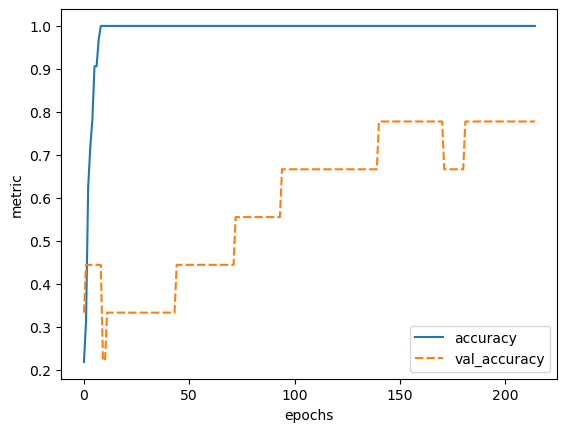

In [21]:
plot_history(history, ["accuracy", "val_accuracy"])

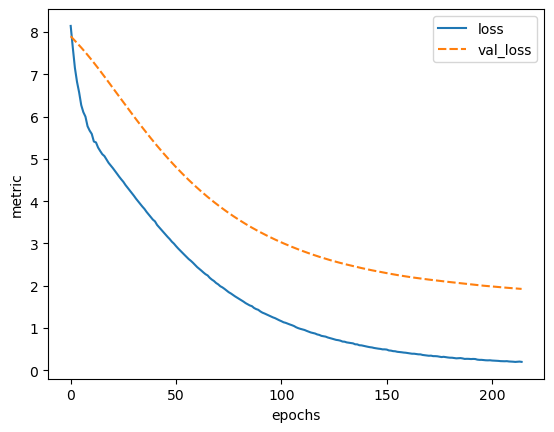

In [22]:
plot_history(history, ["loss", "val_loss"])

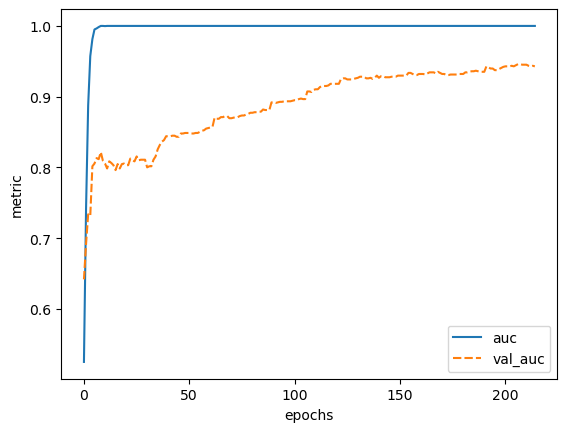

In [24]:
plot_history(history, ["auc", "val_auc"])

The AUC (Area under the curve) of the ROC (Receiver operating characteristic; default) or PR (Precision Recall) curves are quality measures of binary classifiers. 